In [1]:
from scipy import stats, special
import numpy as np
from pathlib import Path
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import awkward as ak
import pandas as pd


def background_cdf(x, N, var):
    return (1 - np.exp( - 1 * (x ** 2) / var)) ** (N)

def background_cdf_awk(x, n_signal, n_sample, var):
    
    N = n_sample - ak.to_numpy(n_signal)
    
    return (1 - np.exp( - 1 * (x ** 2) / var)) ** (N[:, np.newaxis])

def rician_pdf(x, var, loc_val):
    
    x = x[np.newaxis, :]
    loc_val = loc_val[:, np.newaxis]
    
    return x * np.exp( -1 * (x ** 2 + loc_val ** 2) / var ) * special.iv(0, x * 2 * loc_val / var)

def cdf_from_pdf(x, pdf):
    
    cdf = np.zeros((pdf.shape[0], x.size))
    for i in range(x.size):
        
        cdf[:, i] = np.trapz(pdf[:, 0:i+1], x[0:i+1], axis=-1)
        
    return cdf

def combine_batch_cdf(cdf, counts):
    
    count = 0
    cdf_ak = []
    for n in counts:
        cdf_ak.append(cdf[count:count+n, :])
        count+=n
    cdf_ak = ak.Array(cdf_ak)
    
    return ak.to_numpy(ak.prod(cdf_ak, axis=1))

def get_spectra_peaks(freq_spectra, threshold):
    
    peaks = []
    for i in range(freq_spectra.shape[0]):
        i_peak_inds = np.where(abs(freq_spectra[i, :]) > threshold)[0]
        i_peaks = abs(freq_spectra[i, i_peak_inds])

        peaks.append(list(i_peaks))
    
    return ak.Array(peaks)
    
def generate_signal_cdf(peaks, x, var, n_sample, batchsize=1000):
    
    peak_counts = ak.num(peaks, axis=1)
    num_spectra = ak.num(peaks, axis=0)
    
    spectra_inds = np.arange(0, num_spectra, 1)
    combined_cdf = np.zeros((num_spectra, x.size))
    
    for i, spectra_batch in enumerate(np.array_split(spectra_inds, num_spectra//batchsize)):
        
        batch_peaks = peaks[spectra_batch]
        batch_counts = ak.num(batch_peaks, axis=1)
        flat_batch_peaks = ak.to_numpy(ak.flatten(batch_peaks))
        
        batch_pdf = rician_pdf(x, var, flat_batch_peaks)
        batch_norm = 1/np.trapz(batch_pdf, x, axis=-1)
        batch_pdf = batch_norm[:, np.newaxis] * batch_pdf
        
        batch_cdf = cdf_from_pdf(x, batch_pdf)
        batch_cdf = combine_batch_cdf(batch_cdf, batch_counts)

        combined_cdf[spectra_batch, :] = batch_cdf * background_cdf_awk(x, batch_counts, n_sample, var)
        
        if i % 10 == 9:
            print(f'{i + 1} / {num_spectra//batchsize}')
            
    return combined_cdf
    

In [2]:
x = np.arange(0, 100, 1)
print(np.array_split(x, 10))

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39]), array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49]), array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59]), array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69]), array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79]), array([80, 81, 82, 83, 84, 85, 86, 87, 88, 89]), array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99])]


In [3]:
path2signals = Path.home()/'group'/'project'/'results'/'beamforming'/'time_dependent'/'beamform_signals'
file = '220505_dl_grid_84to90deg_1to45mm.h5'

pitch_min=88
pitch_max=90
radius_min=0.001
radius_max=0.045


h5file = h5py.File(path2signals/file, 'r')

metadata = {
    'energy':h5file['energy'][:],
    'pitch':h5file['pitch'][:],
    'radius':h5file['radius'][:]
}

metadata = pd.DataFrame(metadata)

inds = np.array(metadata[
    (metadata['pitch']>=pitch_min)&(metadata['pitch']<=pitch_max)
    & (metadata['radius']>=radius_min)&(metadata['radius']<=radius_max)
].index.array)

signal_freq_spectra = np.fft.fftshift(np.fft.fft(
    h5file['x'][inds, 0:8192], axis=-1, norm='forward'))


In [4]:
signal_freq_spectra.shape

(20091, 8192)

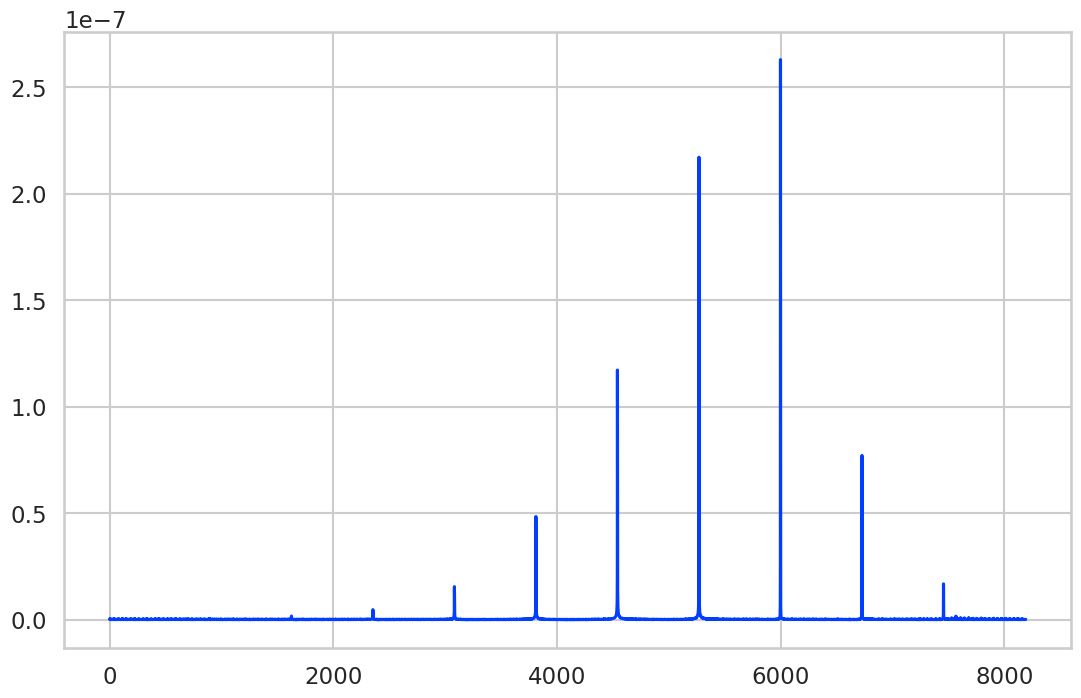

In [5]:
sns.set_theme(context='talk', style='whitegrid', palette='bright')

fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)

ax.plot(abs(signal_freq_spectra[0, :]))
ylims = ax.get_ylim()



In [6]:
peak_threshold = 1e-8
system_noise_temp = 10
n_sample = 8192
noise_variance = 1.38e-23 * 50 * 60 * 205e6 * system_noise_temp / n_sample
n_pts_dist = 101
x = np.linspace(0, 1e-6, n_pts_dist)

peaks = get_spectra_peaks(signal_freq_spectra, peak_threshold)
cdf = generate_signal_cdf(peaks, x, noise_variance, n_sample)


10 / 20
20 / 20


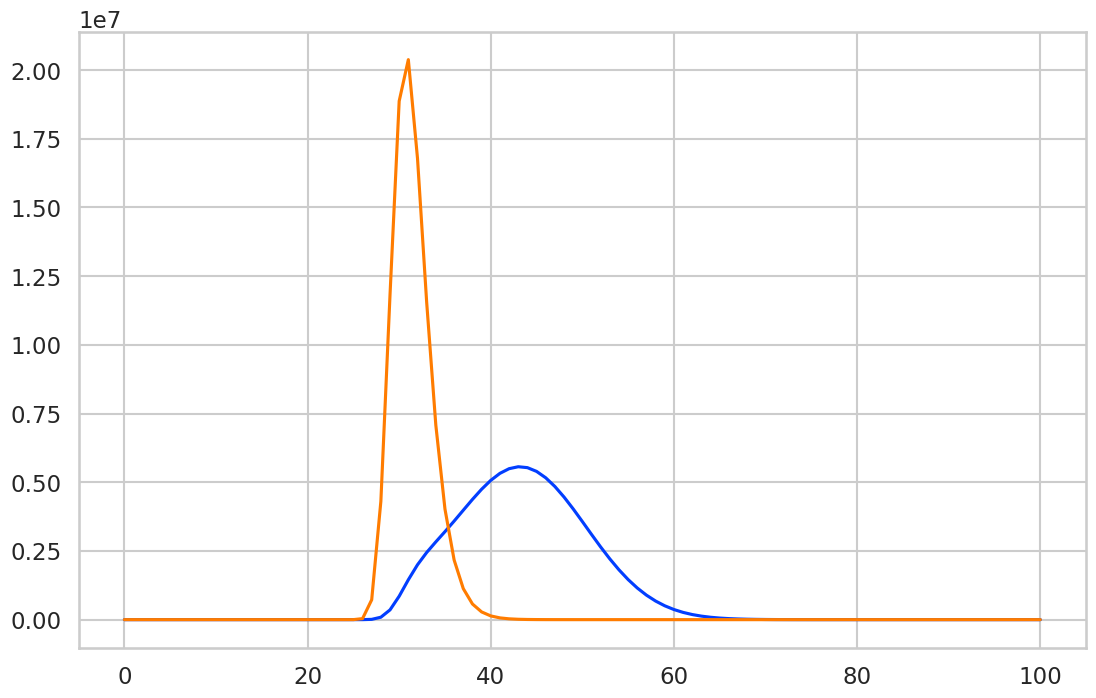

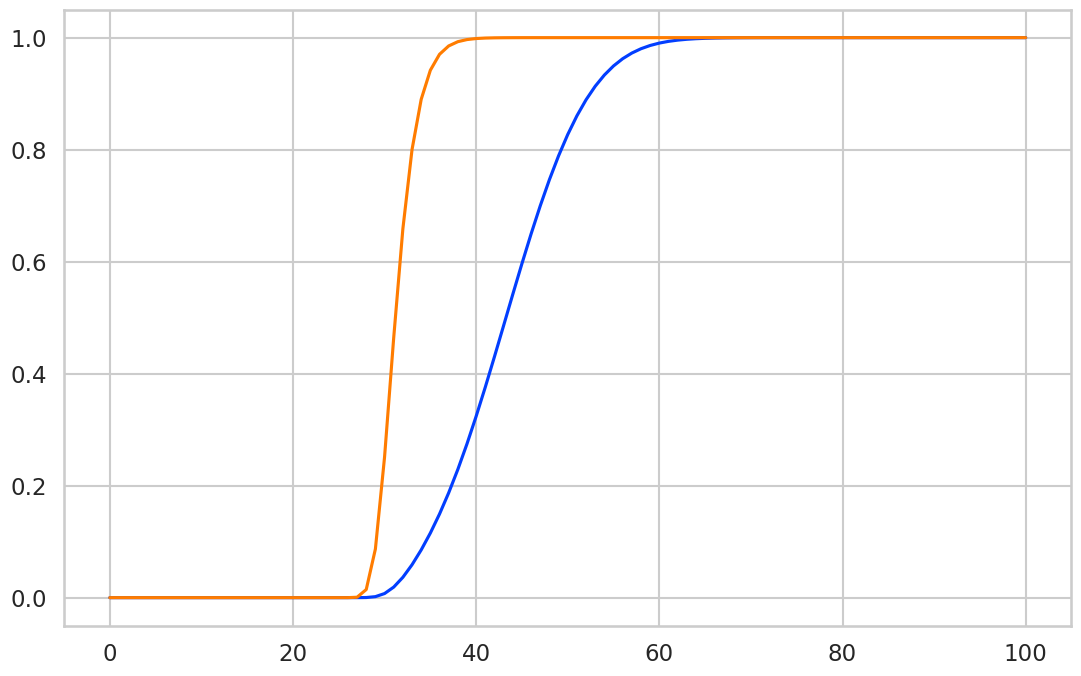

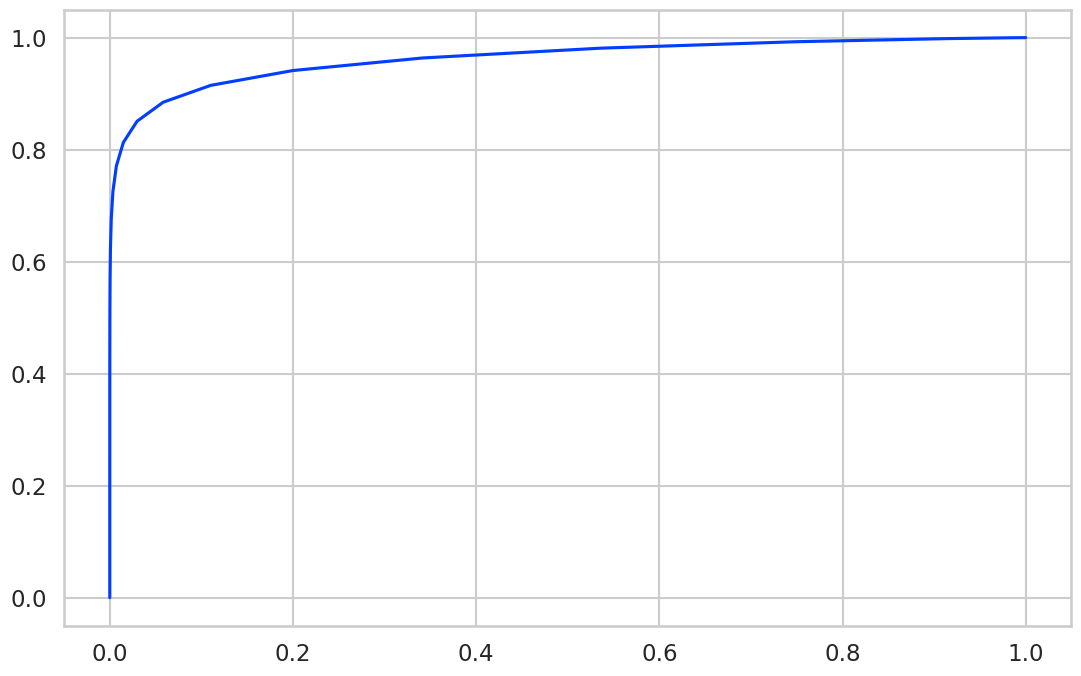

In [7]:
ind = 22

pdf = np.gradient(cdf, axis=-1)
norm = 1/np.trapz(pdf, x)
pdf = norm[:, np.newaxis] * pdf

cdf_background = background_cdf(x, n_sample, noise_variance)
pdf_background = np.gradient(cdf_background) / np.trapz(np.gradient(cdf_background), x)

fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)

ax.plot(pdf[ind, :])
ax.plot(pdf_background)

fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)

ax.plot(cdf[ind, :])
ax.plot(cdf_background)

fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)

ax.plot(1-cdf_background, 1-cdf[ind, :])

(5e-05, 1)

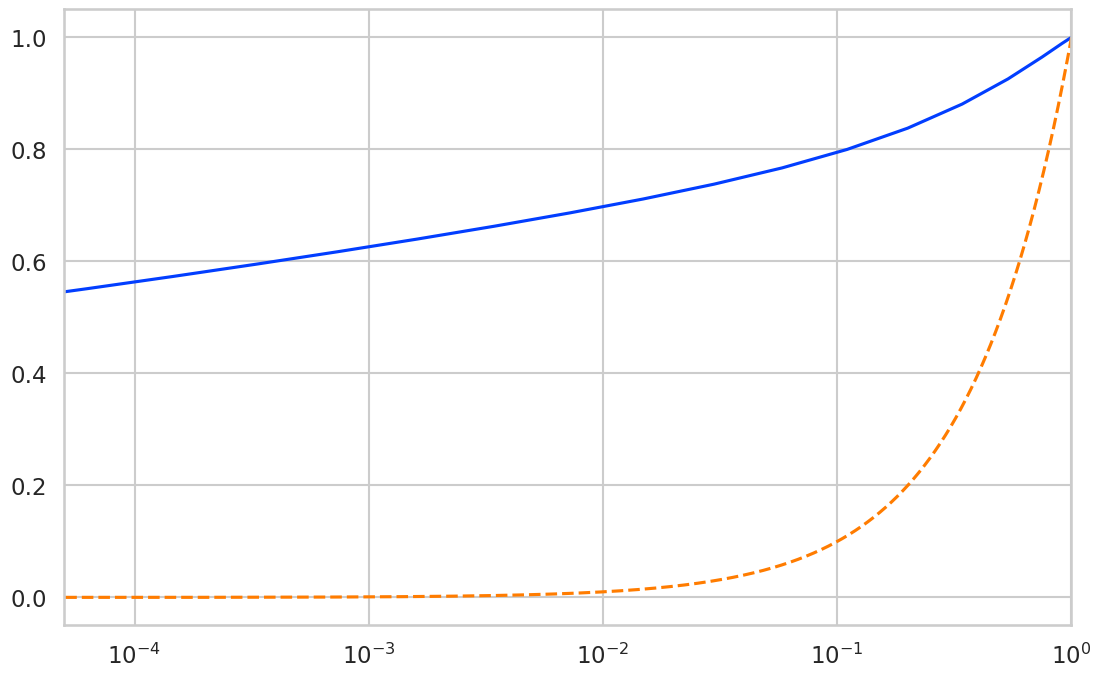

In [8]:
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)

ax.plot(1-cdf_background, 1-cdf.mean(axis=0))
ax.plot(np.linspace(0, 1, 10001), np.linspace(0, 1, 10001), '--')
ax.set_xscale('log')

ax.set_xlim(5e-5, 1)

# Validation

(1000.0, 10000000.0)

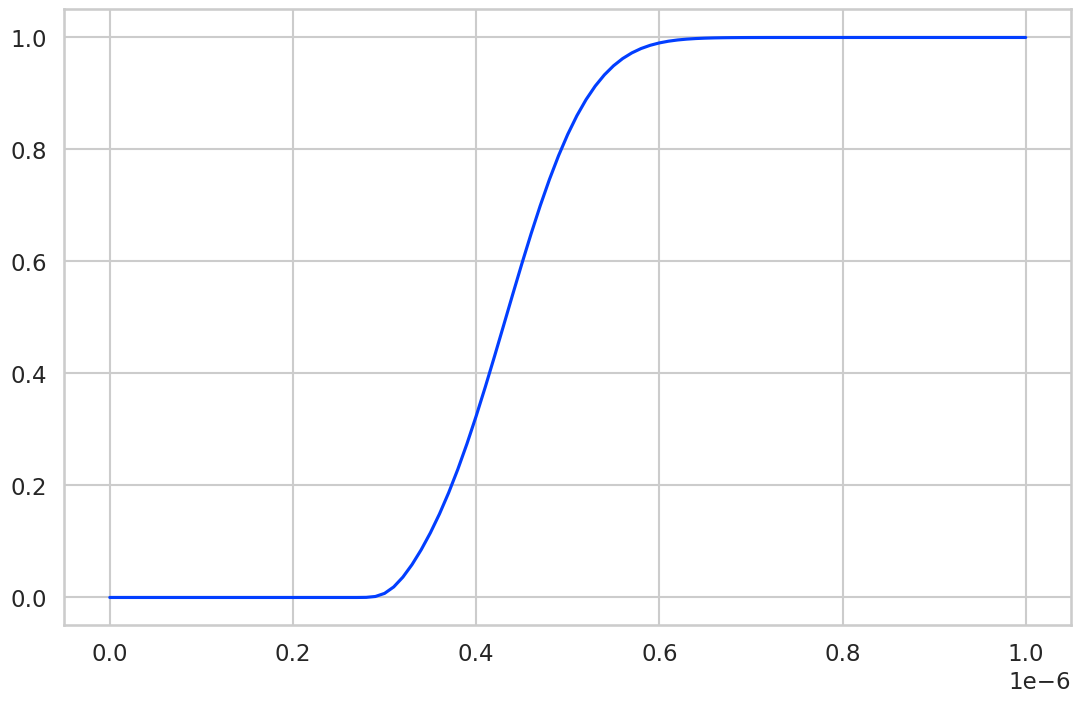

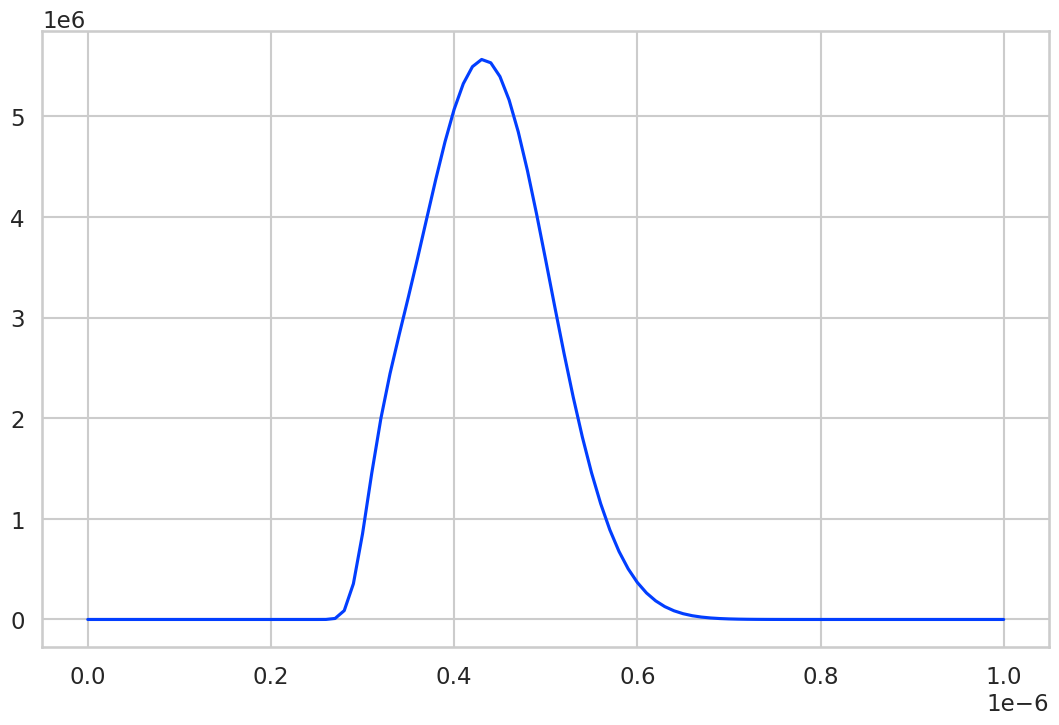

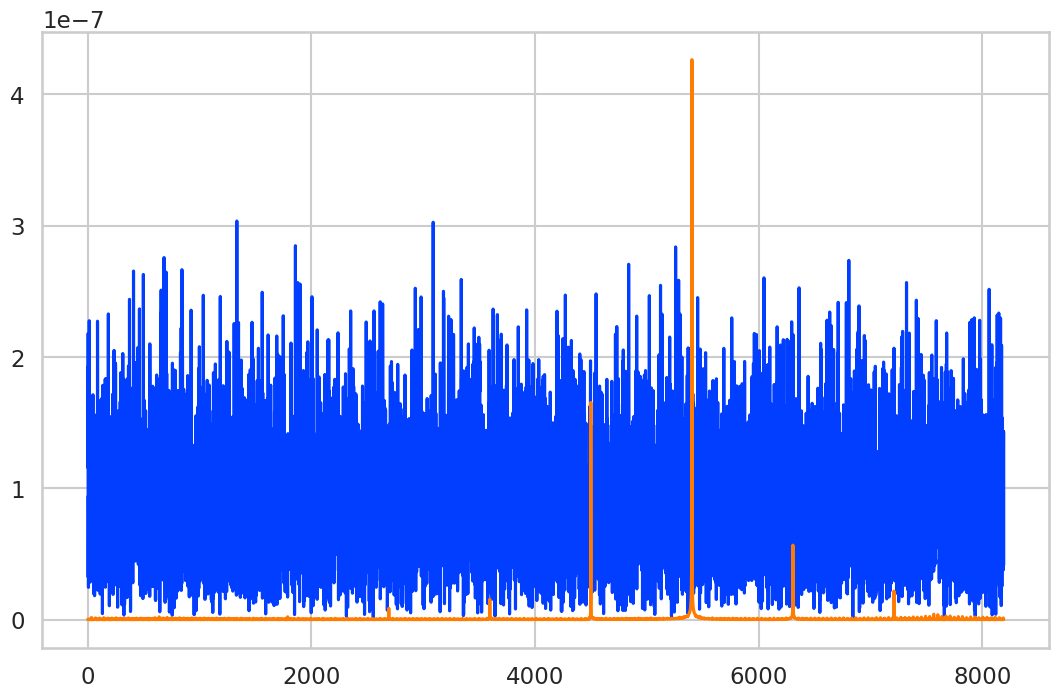

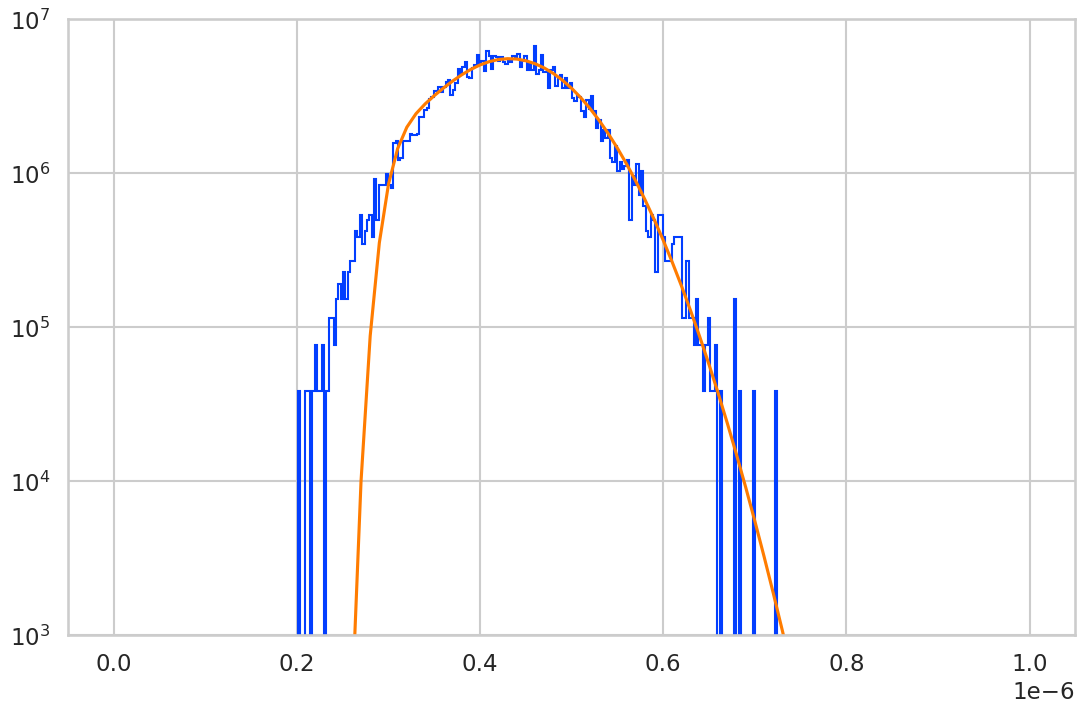

In [9]:
test_index = 22
n_mc = 10000
noise = np.random.multivariate_normal([0, 0], np.eye(2) * noise_variance / 2, n_sample)
noise = noise[:, 0] + 1j * noise[:, 1]

sns.set_theme(context='talk', style='whitegrid', palette='bright')

fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)
ax.plot(x, cdf[test_index, :])
ylims = ax.get_ylim()

fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)
ax.plot(x, np.gradient(cdf[test_index, :]) / np.trapz(np.gradient(cdf[test_index, :]), x))
ylims = ax.get_ylim()

fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)
ax.plot(abs(noise))
ax.plot(abs(signal_freq_spectra[test_index, :]))

test_peak_inds = np.where(abs(signal_freq_spectra[test_index, :])>peak_threshold)[0]
test_max_val = np.zeros(n_mc)
for i in range(n_mc):
    
    noise = np.random.multivariate_normal([0, 0], np.eye(2) * noise_variance / 2, n_sample)
    noise = noise[:, 0] + 1j * noise[:, 1]
    
    test_max_val[i] = np.max(abs(noise + signal_freq_spectra[test_index, :])[test_peak_inds])
    
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(1,1,1)
hist = ax.hist(test_max_val, 201, density=True, histtype='step')
ax.plot(x, np.gradient(cdf[test_index, :]) / np.trapz(np.gradient(cdf[test_index, :]), x))
ax.set_yscale('log')
ax.set_ylim(1e3, 1e7)
  
    

In [10]:
y_cdf.shape

NameError: name 'y_cdf' is not defined

In [ ]:
test_peaks_per_signal = ak.num(test_signal_peaks)

cdf_ak = []
count = 0
for n_peaks in test_peaks_per_signal:
    cdf_ak.append(y_cdf[count:count+n_peaks, :])
    count += n_peaks
cdf_ak = ak.Array(cdf_ak)



In [ ]:
ak.prod(cdf_ak, axis=1)

In [ ]:
np.prod(y_cdf[0:peaks_per_signal[0], :], axis=0).shape

In [ ]:
np.array_split(np.linspace(0, 100), 10)

In [ ]:
x = ak.Array([1,1,1,11,1,1,1,1,1,1,1,1])

In [ ]:
np.array_split(x, 3)